# RE19-classification: performance evaluation

This notebook evaluates the performance of a F and Q requirements classifier in different ways.

## 0. Set up (optional)

Run the following three install functions if running Jupyter on a cloud environment like Colaboratory, which does not allow you to install the libraries permanently on your local machine

In [2]:
#!git clone https://github.com/rulematrix/rule-matrix-py.git
#!pip install rule-matrix-py/.
#!pip install mdlp-discretization
#!pip install pysbrl==0.4.2rc0
#!pip install fim
!pip install cython numpy
#!pip install skope-rules

## 1. Import libraries

In [3]:
#import rulematrix
#from rulematrix.surrogate import rule_surrogate
#from skrules import SkopeRules
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, precision_recall_curve, auc, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.over_sampling import ADASYN 

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_iris

import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import interp

import numpy as np
import pandas as pd

# Set the ipython display in such a way that helps the visualization of the rulematrix outputs.
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## 2. Auxiliary functions

In [0]:
def drop_descriptive_columns(dataset):
    return dataset.drop(['RequirementText', 'Class', 'ProjectID'], axis = 1)

def split_tr_te(dataset, target, to_drop, tsize=0.25):
     return train_test_split(dataset.drop(to_drop, axis=1), dataset[target], test_size=tsize, random_state=42)

def print_scores(actual, pred, name, prob):
    f1 = f1_score(actual, pred, average='micro') 
    prec = precision_score(actual, pred) 
    rec = recall_score(actual, pred) 
    auc = roc_auc_score(actual, prob)
    print('=====', name)
    print('Confusion matrix (test)\n', confusion_matrix(actual, pred))
#     print('F1-Score (micro)', f1)
#     print('Precision', prec)
#     print('Recall (train)', rec, '\n')
    return [name, prec, rec, f1, auc]
    
def build_plot(y_true=[], scores=[], labels=[]):
    gradient = np.linspace(0, 1, 10)
    color_list = [ cm.tab10(x) for x in gradient ]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5),
                         sharex=True, sharey=True)
    ax = axes[0]
    n_line = 0
    for i_score, score in enumerate(scores):
        fpr, tpr, _ = roc_curve(y_true[n_line], score, drop_intermediate=False)
        n_line = n_line + 1
        ax.plot(fpr, tpr, linestyle='-.', c=color_list[i_score], lw=1, label=labels[i_score])
    ax.set_title("ROC", fontsize=20)
    ax.set_xlabel('False Positive Rate', fontsize=18)
    ax.set_ylabel('True Positive Rate (Recall)', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)

    ax = axes[1]
    n_line = 0
    for i_score, score in enumerate(scores):
        precision, recall, _ = precision_recall_curve(y_true[n_line], score)
        n_line = n_line + 1
        ax.step(recall, precision, linestyle='-.', c=color_list[i_score], lw=1, where='post', label=labels[i_score])
    ax.set_title("Precision-Recall", fontsize=20)
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=18)
    ax.set_ylabel('Precision', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)
    plt.show()

        
def train_classifier(model, train_x, train_y, name):
    model.fit(train_x, train_y)
    pred_train = model.predict(train_x)
    prob = model.predict_proba(train_x)[:, 1]
    scores_line = print_scores(train_y, pred_train, name, prob)
    return scores_line, pred_train, prob
  
def evaluate_classifier(model, test_x, test_y, name):
    pred_test = model.predict(test_x)
    prob = model.predict_proba(test_x)[:, 1]
    scores_line = print_scores(test_y, pred_test, name, prob)
    return scores_line, pred_test, prob
  
def makeOverSamplesADASYN(X,y):
  # input DataFrame
  # X : Independent Variable in DataFrame
  # y : Dependent Variable in Pandas DataFrame formats
  sm = ADASYN()
  X, y = sm.fit_sample(X, y)
  return X, y

def make_roc_curve(appendix, target, to_drop, golds, probs, names, scores, nrfeat, colors):
  cv = StratifiedKFold(n_splits=10)
  classifier = svm.SVC(kernel='linear', probability=True, random_state=0)

  # For fast processing
  # from sklearn.ensemble import GradientBoostingClassifier
  # classifier = GradientBoostingClassifier(random_state=42, n_estimators=30, max_depth = 5)

  tprs = []
  aucs = []
  paucs = []
  ptprs = []
  mean_fpr = np.linspace(0, 1, 100)
  pmean_fpr = np.linspace(0, 1, 100)

  plt.figure(figsize=(10,6))

  dataz = pd.read_csv('https://raw.githubusercontent.com/explainable-re/re19-data/master/promise-km-' + str(nrfeat) + '-' + appendix + '.csv', engine='python')

  # Attempt with project-based fold -- TODO: try another partitioning
  # projects = [[3, 9, 11], [1, 5, 12], [6, 10, 13], [1, 8, 14], [3, 10, 12], [2, 5, 11], [4, 6, 14], [7, 8, 13], [2, 9, 15], [4, 7, 15] ]
  projects = [[3, 9, 11], [1, 5, 12], [6, 10, 13], [1, 8, 14], [3, 12, 15], [2, 5, 11], [6, 9, 14], [7, 8, 13], [2, 4, 15], [4, 7, 10] ]
  
  print (target + 'p-fold')
  prec = 0.0
  rec = 0.0
  f1 = 0.0
  for k in projects:
    mytest = dataz.loc[dataz['ProjectID'].isin(k)]
    mytrain = dataz.loc[~dataz['ProjectID'].isin(k)]
    mytest = drop_descriptive_columns(mytest)
    mytest = mytest.drop(mytest.columns[0], axis=1)
    mytrain = drop_descriptive_columns(mytrain)
    mytrain = mytrain.drop(mytrain.columns[0], axis=1)
    myprobs = classifier.fit(mytrain.drop(to_drop, axis=1), 
                             mytrain[target]).predict_proba(mytest.drop(to_drop, axis=1))
    pred = classifier.predict(mytest.drop(to_drop, axis=1))
    prec += precision_score(mytest[target].values.tolist(), pred) 
    rec += recall_score(mytest[target].values.tolist(), pred)
    f1 += f1_score(mytest[target].values.tolist(), pred)
    print (k, 'Precision', prec, 'Recall', rec )
    myfpr, mytpr, _ = roc_curve(mytest[target].values.tolist(), myprobs[:, 1], drop_intermediate=False)
    ptprs.append(interp(pmean_fpr, myfpr, mytpr))
    ptprs[-1][0] = 0.0
    my_auc = auc(myfpr, mytpr)
#     my_auc = roc_auc_score(mytest[target].values.tolist(), myprobs[:, 1])
    paucs.append(my_auc)
    plt.plot(myfpr, mytpr, lw=1, color=colors['Promise test set'], alpha=0.8, linestyle='--',
                 label='Projects bundle %s (AUC = %0.2f)' % (str(k), my_auc))

  print ('p-fold', 'Precision', str(prec/10.0), 'Recall', str(rec/10.0), 'F1', str(f1/10.0), 'AUC', str(my_auc/10.0))  
    
  
  pmean_tpr = np.mean(ptprs, axis=0)
  pmean_tpr[-1] = 1.0
#   pmean_auc = auc(pmean_fpr, pmean_tpr)
  pmean_auc = np.mean(paucs, axis=0)
  std_auc = np.std(paucs)
  plt.plot(pmean_fpr, pmean_tpr, color=colors['Promise test set'], linestyle='--',
           label=r'Mean p-fold (AUC = %0.2f $\pm$ %0.2f)' % (pmean_auc, std_auc),
           lw=2, alpha=.8)

  std_tpr = np.std(ptprs, axis=0)
  tprs_upper = np.minimum(pmean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(pmean_tpr - std_tpr, 0)
  plt.fill_between(pmean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                   label=r'$\pm$ 1 std. dev. from p-fold')
  
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  #plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

  plt.figure(figsize=(10,6))
  
  dataz = drop_descriptive_columns(dataz)
  dataz = dataz.drop(dataz.columns[0], axis=1)

  X = dataz.drop(to_drop, axis=1)
  y = dataz[target]

  # This code plots the ROC curve with cross validation
  print (target + 'k-fold')
  i = 0
  prec = 0.0
  rec = 0.0
  f1 = 0.0
  for train, test in cv.split(X, y):
      probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
      pred = classifier.predict(X.iloc[test])
      prec += precision_score(y.iloc[test], pred) 
      rec += recall_score(y.iloc[test], pred)
      f1 += f1_score(y.iloc[test], pred)
      print (i, 'Precision', prec, 'Recall', rec )
      # Compute ROC curve and area the curve
      fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1], drop_intermediate=False)
      tprs.append(interp(mean_fpr, fpr, tpr))
      tprs[-1][0] = 0.0
      roc_auc = auc(fpr, tpr)
#       roc_auc = roc_auc_score(y.iloc[test], probas_[:, 1])
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=1, alpha=0.3,
               label='k-fold %d (AUC = %0.2f)' % (i, roc_auc))
      i += 1
  
  print ('k-fold', 'Precision', str(prec/10.0), 'Recall', str(rec/10.0), 'F1', str(f1/10.0), 'AUC', str(roc_auc/10))
  
  
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  #plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

# plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#          label='Chance', alpha=.8)

  plt.plot(pmean_fpr, pmean_tpr, color=colors['Promise test set'], linestyle=':',
           label=r'Mean p-fold (AUC = %0.2f $\pm$ %0.2f)' % (pmean_auc, std_auc),
           lw=2, alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
#   mean_auc = auc(mean_fpr, mean_tpr)
  mean_auc = np.mean(aucs, axis=0)
  std_auc = np.std(aucs)
  plt.plot(mean_fpr, mean_tpr, color=colors['Promise test set'], linestyle='--',
           label=r'Mean k-fold (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
           lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                   label=r'$\pm$ 1 std. dev. from k-fold')


  idx = 0
  #colors = ['green', 'brown', 'darkolivegreen', 'purple', 'yellow', 'black', 'red', 'peru']
  for gold in golds:
    fpr, tpr, thresholds = roc_curve(gold, probs[idx])
#     the_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[names[idx]], alpha=0.8,
               label='%s (AUC = %0.2f)' % (names[idx], scores[idx]))
    idx += 1


  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  #plt.title('Receiver operating characteristic')
  #plt.legend(loc="lower right")

  handles, labels = plt.gca().get_legend_handles_labels()
  order = [2, 1, 0]
  
  for i in range(3, len(handles)):
    order.append(i)
  
  print ('The order is', order)
  plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")

  #plt.show()
  print ('roc-' + str(nrfeat) + '-' + appendix + '.pdf')
  plt.savefig('roc-' + str(nrfeat) + '-' + appendix + '.pdf', dpi=300, bbox_inches='tight')

## 3a. Precision, recall, F1, ROC curve

Imports the classified and **enriched** dataset, calculates precision, recall, F1 score and plots the ROC curve

In [12]:
# Linguistic features, committed to GitHub repo
#data = pd.read_csv('https://raw.githubusercontent.com/explainable-re/re19-data/master/promise-enriched.csv', engine='python')

filenames = ['esa-eucl-est', 'ds2', 'ds3', 'dronology', 'reqview', 'leeds', 'wasp']
labels = ['ESA Euclid', 'Helpdesk', 'User mgmt', 'Dronology', 'ReqView', 'Leeds library', 'WASP']
remove = [('dronology', 'f'),('dronology', 'oq'),('wasp', 'f'),('wasp', 'oq')]
oversample = [('ds3', 'f'), ('ds3', 'oq')]
targets = ['IsFunctional', 'IsQuality', 'OnlyFunctional', 'OnlyQuality']
nrfeat = 100

colorpalette = ['#000000', '#e69f00', '#56b4e9', '#009e73', '#f0e442', '#0072b2', '#d55e00', '#cc79a7']
  
colors = {'Promise test set' : colorpalette[0]}
for i in range(0, len(filenames)):
  colors.update({labels[i] : colorpalette[i+1]})

print (colors)
pd.set_option('precision', 3)

allfiles = ['Promise train', 'Promise test', 'Macro-average', 'Micro-average']
allfiles += labels
allresults = pd.DataFrame(allfiles, columns = ['Dataset']) 

# BEGIN Learning curve experimentation

# for target in targets:
#   print ('Target:', target)
#   if target == 'IsFunctional':
#     appendix = 'f'
#     to_drop = ['IsFunctional', 'IsQuality']
#   elif target == 'IsQuality':
#     appendix = 'q'
#     to_drop = ['IsFunctional', 'IsQuality']
#   elif target == 'OnlyQuality':
#     appendix = 'oq'
#     to_drop = ['IsFunctional', 'OnlyQuality']
#   elif target == 'OnlyFunctional':
#     appendix = 'of'
#     to_drop = ['OnlyFunctional', 'IsQuality']

#   data = pd.read_csv('https://raw.githubusercontent.com/explainable-re/re19-data/master/promise-km-' + str(nrfeat) + '-' + appendix + '.csv', engine='python')
#   data = drop_descriptive_columns(data)
#   model = SVC(kernel='linear', C=1, random_state=0, probability=True)
#   for i in [0.1, 0.3, 0.5, 0.7, 0.9]:
#     train_x, test_x, train_y, test_y = split_tr_te(data, target, to_drop, tsize=(1.0-i))
#     scores_line, _, _ = train_classifier(model, train_x, train_y, 'Promise ' + str(i))
#     prediction = model.predict(test_x)
#     acc = accuracy_score(test_y, prediction) 
#     print ('Promise', str(i), acc)
#   for filename in filenames:
#     for i in [0.1, 0.3, 0.5, 0.7, 0.9]:
#       data3 = pd.read_csv(filename + '-tagged-' + str(nrfeat) + '-' + appendix + '.csv', engine='python')
#       data3 = drop_descriptive_columns(data3)
#       train_x, test_x, train_y, test_y = split_tr_te(data3, target, to_drop, tsize=(1.0-i))
#       scores_line, _, _ = train_classifier(model, train_x, train_y, filename + ' ' + str(i))
#       prediction = model.predict(test_x)
#       acc = accuracy_score(test_y, prediction) 
#       print (filename, str(i), acc)      
# END Learning curve experimentation

{'Promise test set': '#000000', 'ESA Euclid': '#e69f00', 'Helpdesk': '#56b4e9', 'User mgmt': '#009e73', 'Dronology': '#f0e442', 'ReqView': '#0072b2', 'Leeds library': '#d55e00', 'WASP': '#cc79a7'}


Target: IsFunctional
===== Promise train
Confusion matrix (test)
 [[213  19]
 [ 20 216]]
===== Promise test
Confusion matrix (test)
 [[67 16]
 [21 53]]
['Promise test', 0.7681159420289855, 0.7162162162162162, 0.7643312101910829, 0.8422338000651254]
===== Promise train
Confusion matrix (test)
 [[280  35]
 [ 38 272]]
['Promise train', 0.8859934853420195, 0.8774193548387097, 0.8832, 0.9410752688172044]
===== esa-eucl-est
Confusion matrix (test)
 [[95 50]
 [45 46]]
===== ds2
Confusion matrix (test)
 [[ 10  19]
 [ 12 131]]
Oversampling ds3
===== ds3
Confusion matrix (test)
 [[112  16]
 [ 35  91]]
===== dronology
Confusion matrix (test)
 [[ 3  0]
 [21 73]]
===== reqview
Confusion matrix (test)
 [[11  1]
 [16 59]]
===== leeds
Confusion matrix (test)
 [[23 18]
 [11 33]]
===== wasp
Confusion matrix (test)
 [[ 3  4]
 [ 6 49]]


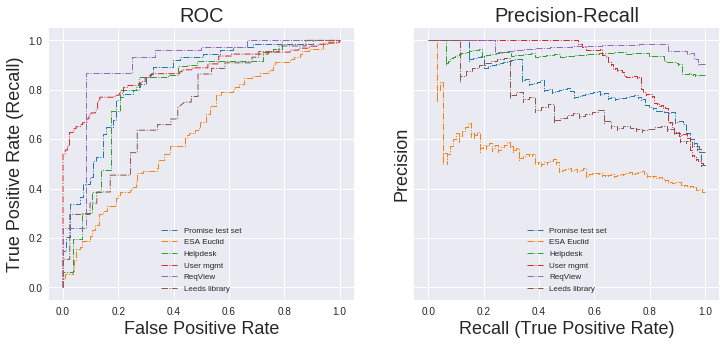

IsFunctionalp-fold
[3, 9, 11] Precision 0.8627450980392157 Recall 0.676923076923077
[1, 5, 12] Precision 1.8627450980392157 Recall 1.317548076923077
[6, 10, 13] Precision 2.537745098039216 Recall 2.0188467782217785
[1, 8, 14] Precision 3.222930283224401 Recall 2.635513444888445
[3, 12, 15] Precision 4.027278109311357 Recall 3.333626652435615
[2, 5, 11] Precision 4.934254853497404 Recall 3.962658910500131
[6, 9, 14] Precision 5.665024084266634 Recall 4.707756949715817
[7, 8, 13] Precision 6.2850240842666345 Recall 5.261328378287246
[2, 4, 15] Precision 7.085024084266634 Recall 6.011328378287246
[4, 7, 10] Precision 7.911111040788374 Recall 6.689899806858675
p-fold Precision 0.7911111040788373 Recall 0.6689899806858675 F1 0.7208987182779006 AUC 0.07940729483282674


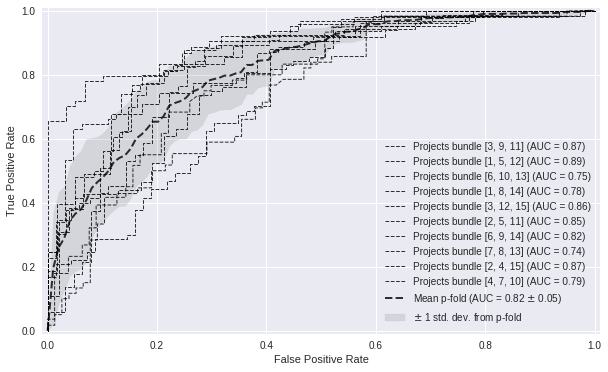

IsFunctionalk-fold
0 Precision 0.8214285714285714 Recall 0.7419354838709677
1 Precision 1.6071428571428572 Recall 1.4516129032258065
2 Precision 2.4071428571428575 Recall 2.225806451612903
3 Precision 3.3271428571428574 Recall 2.967741935483871
4 Precision 4.069078341013825 Recall 3.709677419354839
5 Precision 4.804372458660884 Recall 4.516129032258065
6 Precision 5.535141689430115 Recall 5.129032258064517
7 Precision 6.238845393133818 Recall 5.741935483870969
8 Precision 7.082595393133818 Recall 6.612903225806453
9 Precision 7.817889510780877 Recall 7.419354838709679
k-fold Precision 0.7817889510780878 Recall 0.7419354838709679 F1 0.7593116506078903 AUC 0.08210197710718001


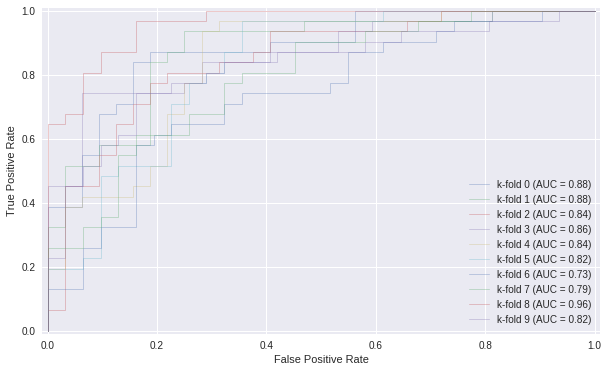

The order is [2, 1, 0, 3, 4, 5, 6, 7, 8]
roc-100-f.pdf


,Dataset,Prec-f,Rec-f,F1-f,AUC-f
0,Promise test,0.768,0.716,0.764,0.842
1,Promise train,0.886,0.877,0.883,0.941
2,esa-eucl-est,0.479,0.505,0.597,0.633
3,ds2,0.873,0.916,0.820,0.803
4,ds3,0.850,0.722,0.799,0.870
5,dronology,1.000,0.777,0.784,0.869
6,reqview,0.983,0.787,0.805,0.898
7,leeds,0.647,0.750,0.659,0.733
8,wasp,0.925,0.891,0.839,0.748
9,Macro-average,0.823,0.764,0.757,0.793


Target: IsQuality
===== Promise train
Confusion matrix (test)
 [[169  18]
 [ 10 271]]
===== Promise test
Confusion matrix (test)
 [[44 12]
 [14 87]]
['Promise test', 0.8787878787878788, 0.8613861386138614, 0.8343949044585988, 0.8847241867043848]
===== Promise train
Confusion matrix (test)
 [[217  26]
 [ 16 366]]
['Promise train', 0.9336734693877551, 0.9581151832460733, 0.9328, 0.9629737358067783]
===== esa-eucl-est
Confusion matrix (test)
 [[ 11  14]
 [ 72 139]]
===== ds2
Confusion matrix (test)
 [[113   8]
 [ 31  20]]
===== ds3
Confusion matrix (test)
 [[62 51]
 [ 9 16]]
===== dronology
Confusion matrix (test)
 [[61  8]
 [14 14]]
===== reqview
Confusion matrix (test)
 [[38 17]
 [19 13]]
===== leeds
Confusion matrix (test)
 [[ 8 16]
 [25 36]]
===== wasp
Confusion matrix (test)
 [[26 17]
 [ 9 10]]


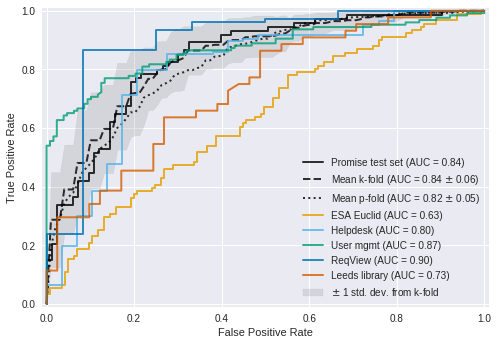

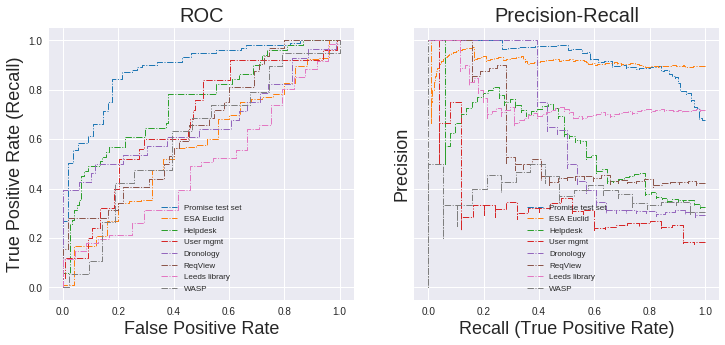

IsQualityp-fold
[3, 9, 11] Precision 0.7183098591549296 Recall 0.9622641509433962
[1, 5, 12] Precision 1.4383098591549297 Recall 1.9352371239163693
[6, 10, 13] Precision 2.05695392695154 Recall 2.8254810263553938
[1, 8, 14] Precision 2.9423705936182065 Recall 3.650723744801996
[3, 12, 15] Precision 3.760552411800025 Recall 4.591022252264683
[2, 5, 11] Precision 4.483324689027747 Recall 5.551548568054156
[6, 9, 14] Precision 5.199233779936838 Recall 6.451548568054156
[7, 8, 13] Precision 6.0376176183206764 Recall 7.265274058250235
[2, 4, 15] Precision 6.837617618320676 Recall 8.118607391583568
[4, 7, 10] Precision 7.431024211727269 Recall 8.989575133519052
p-fold Precision 0.743102421172727 Recall 0.8989575133519052 F1 0.8089324771654537 AUC 0.07262739597942965


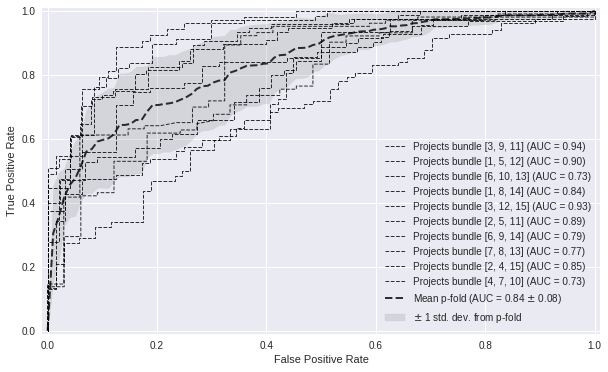

IsQualityk-fold
0 Precision 0.8157894736842105 Recall 0.7948717948717948
1 Precision 1.6907894736842106 Recall 1.6923076923076923
2 Precision 2.5657894736842106 Recall 2.6133603238866394
3 Precision 3.294956140350877 Recall 3.5344129554655868
4 Precision 4.10890962872297 Recall 4.455465587044534
5 Precision 4.8640116695392965 Recall 5.42914979757085
6 Precision 5.608692520603126 Recall 6.350202429149798
7 Precision 6.414248076158682 Recall 7.11336032388664
8 Precision 7.295200457111063 Recall 8.087044534412955
9 Precision 8.078984240894847 Recall 8.850202429149798
k-fold Precision 0.8078984240894848 Recall 0.8850202429149798 F1 0.8423078912759582 AUC 0.07927631578947367


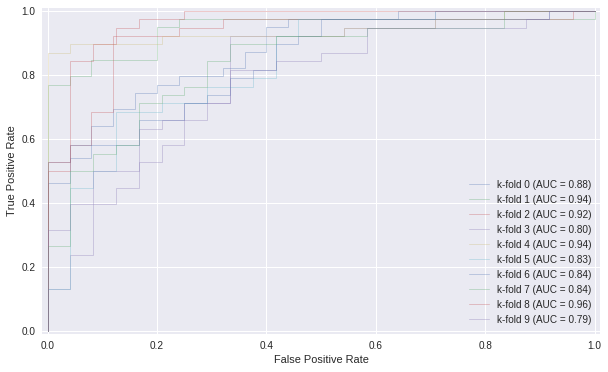

The order is [2, 1, 0, 3, 4, 5, 6, 7, 8, 9, 10]
roc-100-q.pdf


,Dataset,Prec-q,Rec-q,F1-q,AUC-q
0,Promise test,0.879,0.861,0.834,0.885
1,Promise train,0.934,0.958,0.933,0.963
2,esa-eucl-est,0.908,0.659,0.636,0.568
3,ds2,0.714,0.392,0.773,0.749
4,ds3,0.239,0.640,0.565,0.675
5,dronology,0.636,0.500,0.773,0.665
6,reqview,0.433,0.406,0.586,0.649
7,leeds,0.692,0.590,0.518,0.489
8,wasp,0.370,0.526,0.581,0.606
9,Macro-average,0.571,0.531,0.633,0.629


Target: OnlyFunctional
===== Promise train
Confusion matrix (test)
 [[279  13]
 [ 20 156]]
===== Promise test
Confusion matrix (test)
 [[93 10]
 [19 35]]
['Promise test', 0.7777777777777778, 0.6481481481481481, 0.8152866242038217, 0.9075871988493348]
===== Promise train
Confusion matrix (test)
 [[379  16]
 [ 37 193]]
['Promise train', 0.9234449760765551, 0.8391304347826087, 0.9152, 0.9663731425426528]
===== esa-eucl-est
Confusion matrix (test)
 [[171  42]
 [ 18   5]]
===== ds2
Confusion matrix (test)
 [[23 28]
 [29 92]]
===== ds3
Confusion matrix (test)
 [[20  5]
 [62 51]]
===== dronology
Confusion matrix (test)
 [[20  9]
 [40 28]]
===== reqview
Confusion matrix (test)
 [[23 10]
 [20 34]]
===== leeds
Confusion matrix (test)
 [[43 19]
 [18  5]]
===== wasp
Confusion matrix (test)
 [[17  3]
 [13 29]]


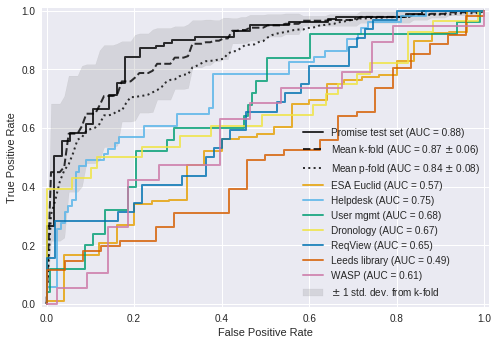

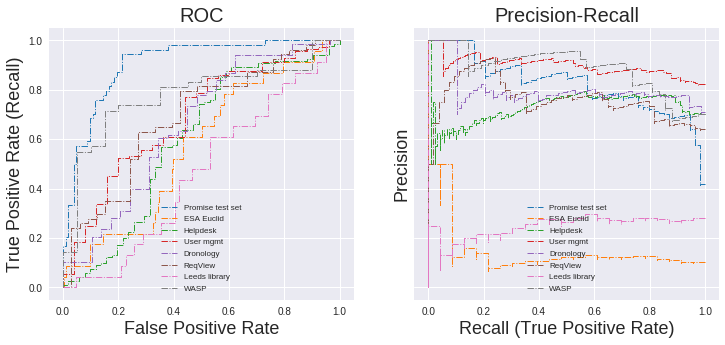

OnlyFunctionalp-fold
[3, 9, 11] Precision 1.0 Recall 0.41379310344827586
[1, 5, 12] Precision 1.8461538461538463 Recall 0.6637931034482758
[6, 10, 13] Precision 2.5384615384615383 Recall 0.9495073891625615
[1, 8, 14] Precision 3.246794871794872 Recall 1.4646589043140765
[3, 12, 15] Precision 4.008699633699633 Recall 1.8549028067531008
[2, 5, 11] Precision 4.956068054752265 Recall 2.2462071545791877
[6, 9, 14] Precision 5.692910160015423 Recall 2.564388972761006
[7, 8, 13] Precision 6.35957682668209 Recall 3.126888972761006
[2, 4, 15] Precision 7.014749240475193 Recall 3.7397921985674576
[4, 7, 10] Precision 7.802628028353981 Recall 4.122145139743928
p-fold Precision 0.7802628028353981 Recall 0.4122145139743928 F1 0.524509031658782 AUC 0.06918767507002802


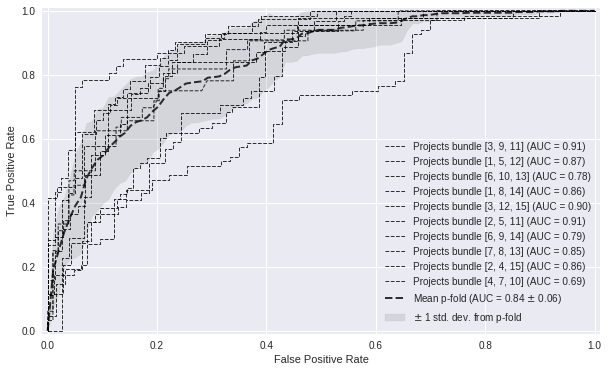

OnlyFunctionalk-fold
0 Precision 0.9230769230769231 Recall 0.5217391304347826
1 Precision 1.827838827838828 Recall 1.3478260869565217
2 Precision 2.4748976513682397 Recall 1.8260869565217392
3 Precision 3.321051497522086 Recall 2.3043478260869565
4 Precision 4.230142406612995 Recall 2.739130434782609
5 Precision 5.01585669232728 Recall 3.217391304347826
6 Precision 5.81585669232728 Recall 3.739130434782609
7 Precision 6.394804060748333 Recall 4.217391304347826
8 Precision 7.342172481800965 Recall 5.0
9 Precision 8.023990663619147 Recall 5.6521739130434785
k-fold Precision 0.8023990663619147 Recall 0.5652173913043479 F1 0.6553442025113851 AUC 0.08784838350055742


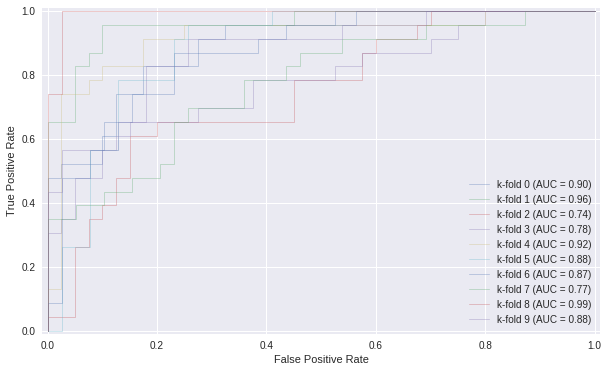

The order is [2, 1, 0, 3, 4, 5, 6, 7, 8, 9, 10]
roc-100-of.pdf


,Dataset,Prec-of,Rec-of,F1-of,AUC-of
0,Promise test,0.778,0.648,0.815,0.908
1,Promise train,0.923,0.839,0.915,0.966
2,esa-eucl-est,0.106,0.217,0.746,0.568
3,ds2,0.767,0.760,0.669,0.597
4,ds3,0.911,0.451,0.514,0.689
5,dronology,0.757,0.412,0.495,0.659
6,reqview,0.773,0.630,0.655,0.689
7,leeds,0.208,0.217,0.565,0.464
8,wasp,0.906,0.690,0.742,0.780
9,Macro-average,0.633,0.483,0.627,0.635


Target: OnlyQuality
===== Promise train
Confusion matrix (test)
 [[221  26]
 [ 22 199]]
===== Promise test
Confusion matrix (test)
 [[59 17]
 [23 58]]
['Promise test', 0.7733333333333333, 0.7160493827160493, 0.7452229299363057, 0.8175763482781027]
===== Promise train
Confusion matrix (test)
 [[279  44]
 [ 38 264]]
['Promise train', 0.8571428571428571, 0.8741721854304636, 0.8688, 0.9352100547434031]
===== esa-eucl-est
Confusion matrix (test)
 [[61 32]
 [78 65]]
===== ds2
Confusion matrix (test)
 [[141   2]
 [ 20   9]]
Oversampling ds3
===== ds3
Confusion matrix (test)
 [[ 98  28]
 [ 19 109]]
===== dronology
Confusion matrix (test)
 [[78 17]
 [ 1  1]]
===== reqview
Confusion matrix (test)
 [[70  6]
 [ 3  8]]
===== leeds
Confusion matrix (test)
 [[42  3]
 [22 18]]
===== wasp
Confusion matrix (test)
 [[48  8]
 [ 3  3]]


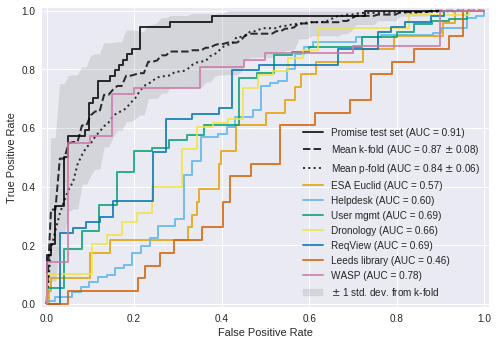

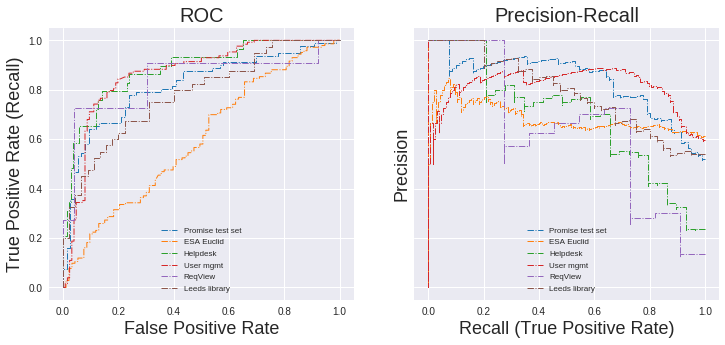

OnlyQualityp-fold
[3, 9, 11] Precision 0.6949152542372882 Recall 0.8913043478260869
[1, 5, 12] Precision 1.4162267296471243 Recall 1.7061191626409018
[6, 10, 13] Precision 2.1420331812600275 Recall 2.3678838685232546
[1, 8, 14] Precision 2.847161386388233 Recall 3.0915680790495705
[3, 12, 15] Precision 3.57443411366096 Recall 3.964295351776843
[2, 5, 11] Precision 4.309728231308019 Recall 4.797628685110176
[6, 9, 14] Precision 5.041071514890108 Recall 5.575406462887954
[7, 8, 13] Precision 5.816071514890108 Recall 6.3702782577597485
[2, 4, 15] Precision 6.623089058749757 Recall 7.163381706035611
[4, 7, 10] Precision 7.296558446504859 Recall 7.880773010383437
p-fold Precision 0.7296558446504859 Recall 0.7880773010383437 F1 0.7560794731135896 AUC 0.08340153452685424


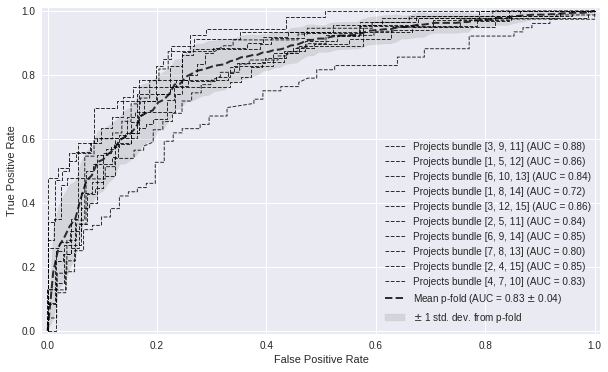

OnlyQualityk-fold
0 Precision 0.7352941176470589 Recall 0.8064516129032258
1 Precision 1.6062618595825429 Recall 1.6774193548387095
2 Precision 2.3007063040269875 Recall 2.510752688172043
3 Precision 3.0194563040269875 Recall 3.2774193548387096
4 Precision 3.8319563040269875 Recall 4.144086021505377
5 Precision 4.617670589741273 Recall 4.87741935483871
6 Precision 5.233055205125888 Recall 5.67741935483871
7 Precision 5.933055205125888 Recall 6.37741935483871
8 Precision 6.891388538459221 Recall 7.144086021505377
9 Precision 7.577102824173507 Recall 7.944086021505377
k-fold Precision 0.7577102824173507 Recall 0.7944086021505377 F1 0.772300568391394 AUC 0.07729166666666668


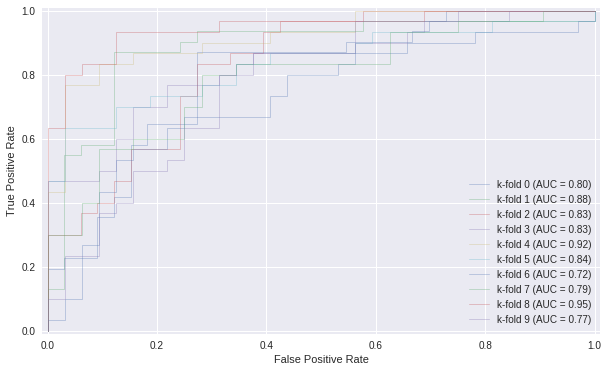

The order is [2, 1, 0, 3, 4, 5, 6, 7, 8]
roc-100-oq.pdf


,Dataset,Prec-oq,Rec-oq,F1-oq,AUC-oq
0,Promise test,0.773,0.716,0.745,0.818
1,Promise train,0.857,0.874,0.869,0.935
2,esa-eucl-est,0.670,0.455,0.534,0.596
3,ds2,0.818,0.310,0.872,0.883
4,ds3,0.796,0.852,0.815,0.864
5,dronology,0.056,0.500,0.814,0.726
6,reqview,0.571,0.727,0.897,0.843
7,leeds,0.857,0.450,0.706,0.783
8,wasp,0.273,0.500,0.823,0.777
9,Macro-average,0.577,0.542,0.780,0.782


,Dataset,Prec-f,Rec-f,F1-f,AUC-f,Prec-q,Rec-q,F1-q,AUC-q,Prec-of,Rec-of,F1-of,AUC-of,Prec-oq,Rec-oq,F1-oq,AUC-oq
0,Promise train,0.886,0.877,0.883,0.941,0.934,0.958,0.933,0.963,0.923,0.839,0.915,0.966,0.857,0.874,0.869,0.935
1,Promise test,0.768,0.716,0.764,0.842,0.879,0.861,0.834,0.885,0.778,0.648,0.815,0.908,0.773,0.716,0.745,0.818
2,Macro-average,0.823,0.764,0.757,0.793,0.571,0.531,0.633,0.629,0.633,0.483,0.627,0.635,0.577,0.542,0.780,0.782


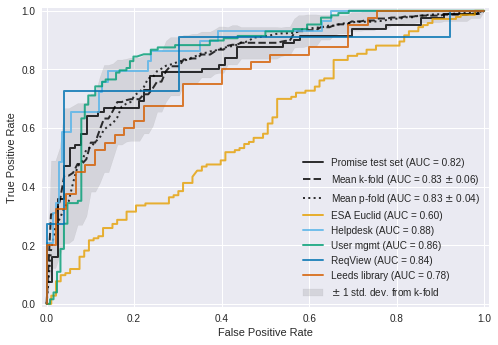

In [13]:
for target in targets:
  print ('Target:', target)
  
  if target == 'IsFunctional':
    appendix = 'f'
    to_drop = ['IsFunctional', 'IsQuality']
  elif target == 'IsQuality':
    appendix = 'q'
    to_drop = ['IsFunctional', 'IsQuality']
  elif target == 'OnlyQuality':
    appendix = 'oq'
    to_drop = ['IsFunctional', 'OnlyQuality']
  elif target == 'OnlyFunctional':
    appendix = 'of'
    to_drop = ['OnlyFunctional', 'IsQuality']
        
  # Kurtanovic replication, from the Github repo
  data = pd.read_csv('https://raw.githubusercontent.com/explainable-re/re19-data/master/promise-km-' + str(nrfeat) + '-' + appendix + '.csv', engine='python')
  
#   data = pd.read_csv('promise-final'  + '.csv', engine='python')
    
  probs = []
  names = []
  golds = []
  auc_scores = []
  data = drop_descriptive_columns(data)
  
  
  # REMOVE ME!!!
#   if target == 'OnlyQuality':
#     data['OnlyQuality'] = data['IsQuality'] & ~data['IsFunctional']
#   elif target == 'OnlyFunctional':
#     data['OnlyFunctional'] = ~data['IsQuality'] & data['IsFunctional']
    
  train_x, test_x, train_y, test_y = split_tr_te(data, target, to_drop)

  #model = MLPClassifier(hidden_layer_sizes=(20,20,20), random_state=43, max_iter=300)
  # mlp_tr, mlp_te, mlp_pr = evaluate_classifier(model, train_x, train_y, test_x, test_y)
  # probs.append(mlp_pr)
  # names.append('MLP-500')

  res = []
  model = SVC(kernel='linear', C=1, random_state=0, probability=True)  
  
  scores_line, _, _ = train_classifier(model, train_x, train_y, 'Promise train')
#   REMOVED: BUG 001
#   print (scores_line)
#   res.append(scores_line)
  scores_line, svm_te, svm_pr = evaluate_classifier(model, test_x, test_y, 'Promise test')
  print (scores_line)
  res.append(scores_line)
  probs.append(svm_pr)
  names.append('Promise test set')
  golds.append(test_y)
  auc_scores.append(scores_line[4])
  
  # ADDED TO FIX THE BUG 001
  model.fit(data.drop(to_drop, axis=1), data[target])
  pred_train = model.predict(data.drop(to_drop, axis=1))
  prob = model.predict_proba(data.drop(to_drop, axis=1))[:, 1]
  scores_line = print_scores(data[target], pred_train, 'Promise train', prob)
  print (scores_line)
  res.append(scores_line)
  
  precisions = []
  recalls = []
  f1s = []
  aucs = []
  idx = 0
  for filename in filenames:
    data3 = pd.read_csv(filename + '-tagged-' + str(nrfeat) + '-' + appendix + '.csv', engine='python')
    
    # REMOVE ME!!!
#     data3 = pd.read_csv(filename + '-final.csv', engine='python')
#     data3['Class'] = ''
#     if target == 'OnlyQuality':
#       data3['OnlyQuality'] = data3['IsQuality'] & ~data3['IsFunctional']
#     elif target == 'OnlyFunctional':
#       data3['OnlyFunctional'] = ~data3['IsQuality'] & data3['IsFunctional']    
    
    data3 = drop_descriptive_columns(data3)
    if (filename, appendix) in oversample:
      print ('Oversampling', filename)
      X, y = makeOverSamplesADASYN(data3.drop(to_drop, axis=1), data3[target])
    else:
      X = data3.drop(to_drop, axis=1)
      y = data3[target]
    scores_line, svm_te, svm_pr = evaluate_classifier(model, X, y, filename)
    precisions.append(scores_line[1])
    recalls.append(scores_line[2])
    f1s.append(scores_line[3])
    aucs.append(scores_line[4])
    res.append(scores_line)
    if (filename, appendix) not in remove:
      probs.append(svm_pr)
      names.append(labels[idx])
      auc_scores.append(scores_line[4])
      if (filename, appendix) in oversample:
        golds.append(y)
      else:
        golds.append(y.values.tolist())
    idx = idx + 1
  
  res.append(['Macro-average', np.mean(precisions), np.mean(recalls), np.mean(f1s), np.mean(aucs)])
  res.append(['Std-dev', np.std(precisions), np.std(recalls), np.std(f1s), np.std(aucs)])
  
  build_plot(y_true=golds, scores=probs, labels=names)
  make_roc_curve(appendix, target, to_drop, golds, probs, names, auc_scores, nrfeat, colors)  
  results = pd.DataFrame(res, columns = ['Dataset', 'Prec-' + appendix, 'Rec-' + appendix, 'F1-' + appendix, 'AUC-' + appendix]) 
  display(HTML(results.to_html()))
  
  allresults = pd.merge(allresults, results, on='Dataset')
  
display(HTML(allresults.to_html()))




### Export to Latex

In [0]:
pd.set_option('precision', 2)
print (allresults.to_latex(escape=False, index=False))

filenames = ['promise-reclass', 'esa-eucl-est', 'ds2', 'ds3', 'dronology', 'reqview', 'leeds', 'wasp']

rez = []
for filename in filenames:
  data3 = pd.read_csv(filename + '.csv', engine='python')
  reqsn = len(data3)
  fr = len(data3[(data3['IsFunctional']==1)])
  qr = len(data3[(data3['IsQuality']==1)])
  ofr = len(data3[(data3['IsFunctional']==1) & (data3['IsQuality']==0)])
  oqr = len(data3[(data3['IsFunctional']==0) & (data3['IsQuality']==1)])
  fqr = len(data3[(data3['IsFunctional']==1) & (data3['IsQuality']==1)])
  nor = len(data3[(data3['IsFunctional']==0) & (data3['IsQuality']==0)])
  rez.append([filename, reqsn, fr, qr, ofr, oqr, fqr, nor])

stats = pd.DataFrame(rez, columns = ['Dataset', 'Rows', 'Functional', 'Quality', 'OnlyFunctional', 'OnlyQuality', 'Func&Qual', 'NoRequirement']) 
stats = stats.append(stats.select_dtypes(pd.np.number).sum().rename('total'))
stats.at['total', 'Dataset'] = 'Totals'

pd.set_option('precision', 0)
print (stats.to_latex(escape=False, index=False))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
       Dataset &  Prec-f &  Rec-f &   F1-f &  Prec-q &  Rec-q &   F1-q &  Prec-of &  Rec-of &  F1-of &  Prec-oq &  Rec-oq &  F1-oq \\
\midrule
 Promise train &   0.919 &  0.915 &  0.917 &   0.938 &  0.964 &  0.940 &    0.923 &   0.886 &  0.929 &    0.884 &   0.900 &  0.897 \\
  Promise test &   0.768 &  0.716 &  0.764 &   0.879 &  0.861 &  0.834 &    0.778 &   0.648 &  0.815 &    0.773 &   0.716 &  0.745 \\
 Macro-average &   0.834 &  0.827 &  0.792 &   0.560 &  0.523 &  0.627 &    0.621 &   0.439 &  0.607 &    0.612 &   0.499 &  0.796 \\
 Micro-average &   0.786 &  0.793 &  0.769 &   0.601 &  0.517 &  0.626 &    0.563 &   0.420 &  0.633 &    0.658 &   0.482 &  0.756 \\
     dronology &   0.987 &  0.787 &  0.784 &   0.619 &  0.464 &  0.763 &    0.750 &   0.397 &  0.485 &    0.071 &   0.500 &  0.856 \\
           ds2 &   0.899 &  0.930 &  0.855 &   0.571 &  0.314 &  0.727 &    0.802 &   0.769 &  0.703 &    0.818 &   0.310 &  0.872 \\
           ds

## 4. Learning curve

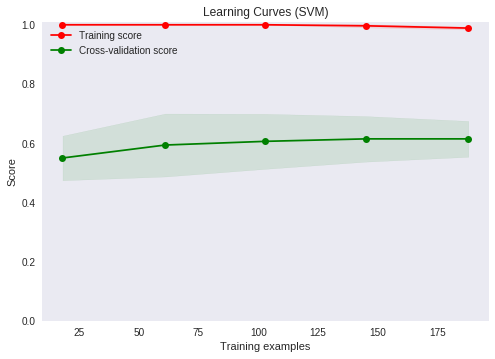

In [0]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
  
#print (X)

title = r"Learning Curves (SVM)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(kernel='linear', C=1, random_state=0, probability=True)
plot_learning_curve(estimator, title, X, y, (0.0, 1.01), cv=cv, n_jobs=4)

plt.show()

## 5. Skope rules

In [0]:
X_train, X_test, y_train, y_test = split_tr_te(dataz, target, to_drop)
feature_names = X_train.columns

# Train a skope-rules-boosting classifier
# TODO We can tune precision and recall here!!!!
skope_rules_clf = SkopeRules(feature_names=feature_names, random_state=42, n_estimators=30,
#                               recall_min=0.05, precision_min=0.9,
                               recall_min=0.05, precision_min=0.8,
                               max_samples=0.7,
                               max_depth_duplication= 4, max_depth = 5)


skope_rules_clf.fit(X_train, y_train)

# Compute prediction scores
baseline_svm = classifier.predict_proba(X_test)[:, 1]

skope_rules_scoring = skope_rules_clf.score_top_rules(X_test)

# Get number of survival rules created
print(str(len(skope_rules_clf.rules_)) + ' rules have been built with ' +
      'SkopeRules.\n')

nrules = len(skope_rules_clf.rules_)

# print('The most performing rules are the following one:\n')
# for i_rule, rule in enumerate(skope_rules_clf.rules_):
#     print("R" + str(i_rule + 1) + ". " + rule[0])
#     #print('-> '+rules_explanations[i_rule]+ '\n')
    
def compute_y_pred_from_query(X, rule):
    score = np.zeros(X.shape[0])
    X = X.reset_index(drop=True)
    score[list(X.query(rule).index)] = 1
    return(score)

def compute_performances_from_y_pred(y_true, y_pred, index_name='default_index'):
    df = pd.DataFrame(data=
        {
            'precision':[sum(y_true * y_pred)/sum(y_pred)],
            'recall':[sum(y_true * y_pred)/sum(y_true)]
        },
        index=[index_name],
        columns=['precision', 'recall']
    )
    return(df)

def compute_train_test_query_performances(X_train, y_train, X_test, y_test, rule):
    
    y_train_pred = compute_y_pred_from_query(X_train, rule)
    y_test_pred = compute_y_pred_from_query(X_test, rule)
    
    performances = None
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_train, y_train_pred, 'train_set')],
        axis=0)
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_test, y_test_pred, 'test_set')],
        axis=0)
            
    return(performances)



for i in range(nrules):
    print('Rule '+str(i+1)+':',skope_rules_clf.rules_[i][0])
    display(compute_train_test_query_performances(X_train, y_train,
                                                  X_test, y_test,
                                                  skope_rules_clf.rules_[i][0])
           )

In [0]:
def plot_scores(y_true, scores_with_line=[], scores_with_points=[],
                        labels_with_line=['SVM'],
                        labels_with_points=['skope-rules']):
    gradient = np.linspace(0, 1, 10)
    color_list = [ cm.tab10(x) for x in gradient ]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5),
                         sharex=True, sharey=True)
    ax = axes[0]
    n_line = 0
    for i_score, score in enumerate(scores_with_line):
        n_line = n_line + 1
        fpr, tpr, _ = roc_curve(y_true, score)
        ax.plot(fpr, tpr, linestyle='-.', c=color_list[i_score], lw=1, label=labels_with_line[i_score])
    for i_score, score in enumerate(scores_with_points):
        fpr, tpr, _ = roc_curve(y_true, score)
        ax.scatter(fpr[:-1], tpr[:-1], c=color_list[n_line + i_score], s=10, label=labels_with_points[i_score])
    ax.set_title("ROC", fontsize=20)
    ax.set_xlabel('False Positive Rate', fontsize=18)
    ax.set_ylabel('True Positive Rate (Recall)', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)

    ax = axes[1]
    n_line = 0
    for i_score, score in enumerate(scores_with_line):
        n_line = n_line + 1
        precision, recall, _ = precision_recall_curve(y_true, score)
        ax.step(recall, precision, linestyle='-.', c=color_list[i_score], lw=1, where='post', label=labels_with_line[i_score])
    for i_score, score in enumerate(scores_with_points):
        precision, recall, _ = precision_recall_curve(y_true, score)
        ax.scatter(recall, precision, c=color_list[n_line + i_score], s=10, label=labels_with_points[i_score])
    ax.set_title("Precision-Recall", fontsize=20)
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=18)
    ax.set_ylabel('Precision', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)
    plt.show()
    
plot_scores(y_test,
                    scores_with_line=[baseline_svm],
                    scores_with_points=[skope_rules_scoring]
                   )

y_pred = skope_rules_clf.predict_top_rules(X_test, nrules)
y_pred2 = skope_rules_clf.predict_top_rules(X_train, nrules)


print('The performances reached with '+str(nrules)+' discovered rules are the following:')
print(compute_performances_from_y_pred(y_train, y_pred2, 'train_set'))
print(compute_performances_from_y_pred(y_test, y_pred, 'test_set'))


## 5. TO-BE-FIXED Here starts the part with RuleMatrix

In [0]:

# def train_nn(neurons=(20,), **kwargs):
#     model = MLPClassifier(hidden_layer_sizes=neurons, **kwargs)
#     if is_categorical is not None:
#         model = Pipeline([
#             ('one_hot', OneHotEncoder(categorical_features=is_categorical)),
#             ('mlp', model)
#         ])
#     model.fit(train_x, train_y)
#     train_score = model.f1_score(train_x, train_y)
#     test_score = model.f1_score(test_x, test_y)
#     print('Training score:', train_score)
#     print('Test score:', test_score)
#     return model


# # FD: I changed max_iter to 300 to help the NN converge
# #nn = train_nn((20, 20, 20), random_state=43, max_iter=300)

# from sklearn.model_selection import cross_validate
# from sklearn.metrics import recall_score

# # Fix hidden_layer_sizes
# #model = MLPClassifier(hidden_layer_sizes=(20,20,20), random_state=43, max_iter=300)
# from sklearn.svm import SVC
# model = SVC(kernel='linear', C=1, random_state=0)
# scoring = ['precision_macro', 'recall_macro']
# scores = cross_validate(model, data.drop([target], axis=1), data[target], scoring=scoring, cv=10, return_train_score=False)
# sorted(scores.keys())
# #scores['train_precision_macro']
# #scores['train_recall_macro']

# print('Precision: ' + str(sum(scores['test_precision_macro'])/10))
# print('Recall: ' + str(sum(scores['test_recall_macro'])/10))

In [0]:
# def train_surrogate(model, sampling_rate=2.0, **kwargs):
#     surrogate = rule_surrogate(model.predict, train_x, sampling_rate=sampling_rate,
#                                is_continuous=is_continuous,
#                                is_categorical=is_categorical,
#                                is_integer=is_integer,
#                                rlargs={'feature_names': feature_names, 'verbose': 2},
#                                **kwargs)

#     train_fidelity = surrogate.score(train_x)
#     test_fidelity = surrogate.score(test_x)
#     print('Training fidelity:', train_fidelity)
#     print('Test fidelity:', test_fidelity)
#     return surrogate

# model.fit(train_x, train_y)
# train_score = model.f1_score(train_x, train_y)
# test_score = model.f1_score(test_x, test_y)
# print('Training score:', train_score)
# print('Test score:', test_score)
    
# surrogate = train_surrogate(model, 4, seed=44)
# rl = surrogate.student
# print(rl)

In [0]:
 
# rulematrix.render(train_x.values.astype('float64'), train_y.values.astype('float64'), surrogate, 
#        feature_names=feature_names, target_names=target_names, 
#        is_categorical=is_categorical)
